In [9]:
%matplotlib inline

import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set(style="ticks", color_codes=True)

from sklearn.metrics import f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from unbalanced_dataset.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

## Getting the SMOTE python package

To use the SMOTE package there are two good options. 

There is a pip install method with [directions](http://contrib.scikit-learn.org/imbalanced-learn/install.html#install).

You can also get it by doing the following steps (this is what I did):

git clone https://github.com/fmfn/UnbalancedDataset.git 
cd UnbalancedDataset 
python setup.py install

The setup is done so that this does not have to be in the same path as other work you are doing. 

### The options for running SMOTE
The smote function that comes from the repository has a number of optional arguments listed in the wiki https://github.com/fmfn/UnbalancedDataset/wiki.  These options for SMOTE are :

1. 'regular'
2. 'borderline1'
3. 'borderline2'
4. 'svm'

The wiki discusses the optional arguments that one can use with each of these types. These are tuning parameters one could learn using cross-validation.  For this discussion we focus on the 'regular' method.  

## The data

We use the yeast data set avaible through the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/Yeast). I exported the data, preprocessed for certain one versus other groupings from the [KEEL data repository](http://www.keel.es/).  The [UCI repository](https://archive.ics.uci.edu/ml/datasets.html) is extensive and useful.  More information and references for this data set are available there, we give a very brief summary here as we are not concerned with feature selection or the deeper biological aspects of this data set right now.  These would be interesting for further study.  

There are 1484 samples with 9 attributes total.  The attributes consist of 8 predictors and the corresponding classifications. The categories consist of 10 localization sites of certain proteins.  We discuss three possible one vs. other categorizations.  Following the labels in the Keel repository, Yeast1 is the Nuclear (or NUC) location vs. the rest, Yeast3 is the ME3 location vs. the rest, and Yeast6 is the Extracellular (or EXC) location vs. the rest.  Detailed descriptions are available on the Data Set Description page within the UCI repository.  We chose this dataset and class breakdown because, within a single data set, we can see how class size works with SMOTE.  Here are the breakdowns for the class sizes for the three datasets. 


Yeast1:  429 minority samples, 28.9%

Yeast3:  163 minority samples, 10.99%

Yeast6:   37 minority samples,  2.36%

In [10]:
#Load the three data sets. 

df1 = pd.read_csv('/Users/ataylor/Insight/blogPosts/FastForwardLabs/yeast1.csv') #Yeast1
df3 = pd.read_csv('/Users/ataylor/Insight/blogPosts/FastForwardLabs/yeast3.csv') #Yeast3
df6 = pd.read_csv('/Users/ataylor/Insight/blogPosts/FastForwardLabs/yeast6.csv') #Yeast6

In [11]:
#Sanity check on sizes of minority classes.

print len(df1[df1.Class == 'positive'])
print len(df3[df3.Class == 'positive'])
print len(df6[df6.Class == 'positive'])

429
163
35


In [12]:
#Some classifiers and other functions behave better when the classes 
#are 0/1 and the variable name is not "Class".

df1['Class'] = df1['Class'].replace({'negative':0, 'positive':1  })
df1 = df1.rename(columns = {'Class':'category'})
df3['Class'] = df3['Class'].replace({'negative':0, 'positive':1  })
df3 = df3.rename(columns = {'Class':'category'})
df6['Class'] = df6['Class'].replace({'negative':0, 'positive':1  })
df6 = df6.rename(columns = {'Class':'category'})

### Train/Test/Validate

When training predictive models, it is standard practice to split a dataset into a training set, a testing set and a validation set.  The validation set is locked in a proverbial vault and only used after model selection to give the error rates/scores.  This setup helps prevent overfitting and ensures generalizability of the model.  However, for smaller datasets and, especially those with large imbalances, this approach is not always available.  We combine training and testing for Yeast1 and Yeast3, by using cross-validation, but still split off a validation set.

For Yeast6 we only use cross-validation for evaluation.  This leaves us not knowing the generalizability of these models, but the alternative is training models on an even smaller set of data than we already have. 

Further, since our goal is to illustrate the behavior of SMOTE, we also do a cross-validation training on the full Yeast1 and Yeast3 data sets to compare to the performance when we split the sets.  Note in practice, one should ALWAYS validate models whenever possible and the challenge we face here is not due to the percentage of the minority class, but the fact that there are fewer than 50 samples in the case of Yeast6.    

In [13]:
# Splitting Yeast1 into training and validation dataframes. 
# We use 75% of the data for training and 25% for validation.

df1_nuc = df1[df1.category == 1]
df1_other = df1[df1.category==0]
train_nuc = df1_nuc.sample(frac = 0.75)
train_other = df1_other.sample(frac = 0.75)
validate_nuc = df1_nuc[~df1_nuc.index.isin(train_nuc.index)]
validate_other = df1_other[~df1_other.index.isin(train_other.index)]
train1 = train_nuc.append(train_other)
validate1 = validate_nuc.append(validate_other)

In [14]:
# Splitting Yeast3 into training and validation dataframes. 

df3_nuc = df3[df3.category == 1]
df3_other = df3[df3.category==0]
train_nuc = df3_nuc.sample(frac = 0.75, random_state = 17)
train_other = df3_other.sample(frac = 0.75, random_state = 42)
validate_nuc = df3_nuc[~df3_nuc.index.isin(train_nuc.index)]
validate_other = df3_other[~df3_other.index.isin(train_other.index)]
train3 = train_nuc.append(train_other)
validate3 = validate_nuc.append(validate_other)

## Graphing the data

We run graph the first two components of the principal components analysis so we can get a 2-D picture to see what, if any separation there is between the classes.  This will give us a sense of whether or not we expect models to perform well and if we should be thinking linearly, or, for example, try a non-linear model like svm with rbf kernel. 

For Yeast1 and Yeast3 we graph the training sets.  

In [15]:
X_columns = list(df1.columns.values)[:-1]
X1 = train1.as_matrix(columns = X_columns)
y1 = (train1['category'].as_matrix()).reshape(len(train1.index),1)

X3 = train3.as_matrix(columns = X_columns)
y3 = (train3['category'].as_matrix()).reshape(len(train3.index),1)

X6 = df6.as_matrix(columns = X_columns)
y6 = (df6['category'].as_matrix()).reshape(len(df6.index),1)

In [16]:
target_names = ['other', 'protein location']

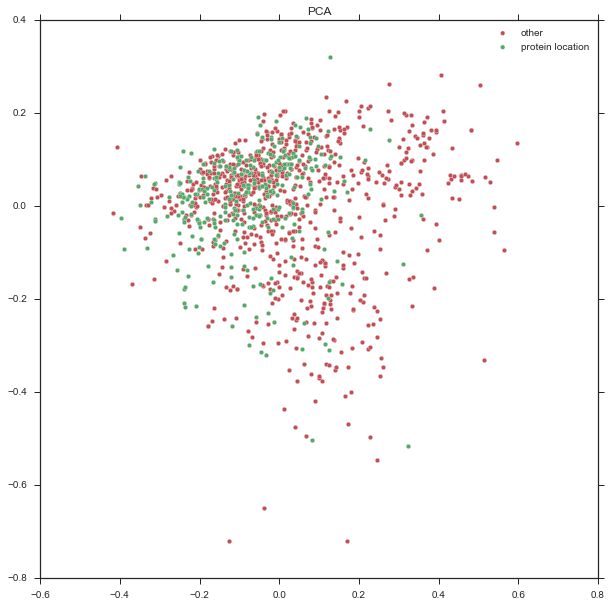

In [17]:
X_graph = X1
y_graph = y1

pca = PCA(n_components=2)
X_r = pca.fit(X_graph).transform(X_graph)
X_r0 = (X_r[:,0]).reshape((X_r[:,0]).shape[0],1)
X_r1 = (X_r[:,1]).reshape((X_r[:,1]).shape[0],1)

plt.figure(figsize=(10,10))
for c, i, target_name in zip("rg", [0, 1], target_names):
    plt.scatter(X_r0[y_graph == i], X_r1[y_graph == i], c=c, label=target_name)
plt.legend()
plt.title('PCA')

plt.show()

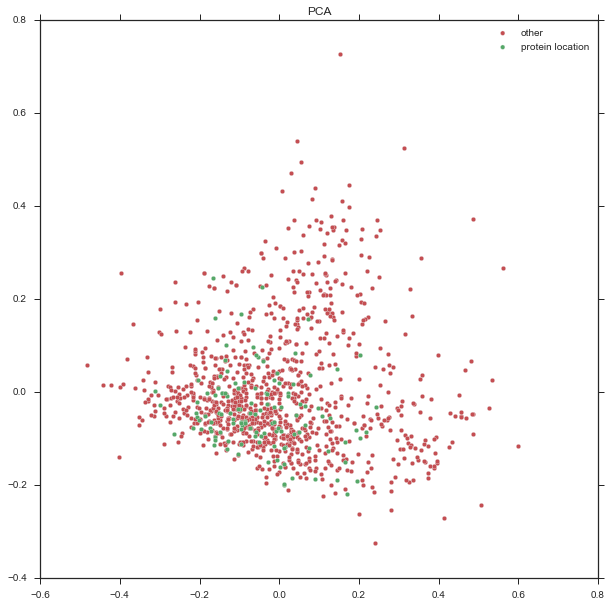

In [18]:
X_graph = X3
y_graph = y3

pca = PCA(n_components=2)
X_r = pca.fit(X_graph).transform(X_graph)
X_r0 = (X_r[:,0]).reshape((X_r[:,0]).shape[0],1)
X_r1 = (X_r[:,1]).reshape((X_r[:,1]).shape[0],1)

plt.figure(figsize=(10,10))
for c, i, target_name in zip("rg", [0, 1], target_names):
    plt.scatter(X_r0[y_graph == i], X_r1[y_graph == i], c=c, label=target_name)
plt.legend()
plt.title('PCA')

plt.show()

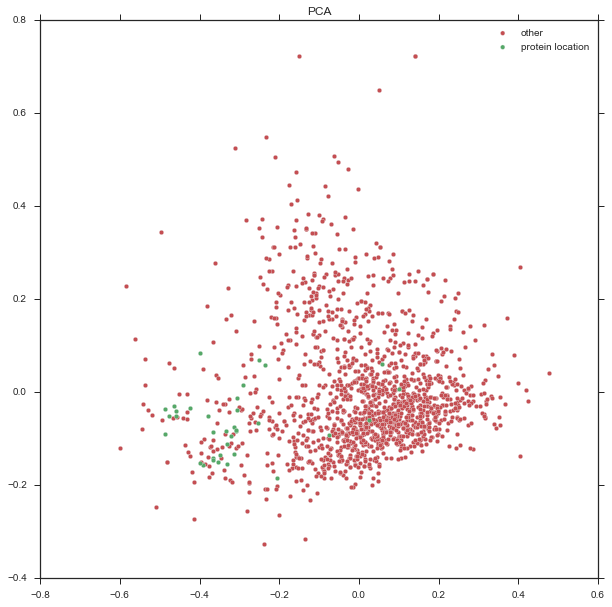

In [19]:
X_graph = X6
y_graph = y6

pca = PCA(n_components=2)
X_r = pca.fit(X_graph).transform(X_graph)
X_r0 = (X_r[:,0]).reshape((X_r[:,0]).shape[0],1)
X_r1 = (X_r[:,1]).reshape((X_r[:,1]).shape[0],1)

plt.figure(figsize=(10,10))
for c, i, target_name in zip("rg", [0, 1], target_names):
    plt.scatter(X_r0[y_graph == i], X_r1[y_graph == i], c=c, label=target_name)
plt.legend()
plt.title('PCA')

plt.show()

It looks like training for Yeast1 may be tough, Yeast3 a little better and Yeast6 has some separation, but also very few samples.  While the dataset, overall, is the same, remember we took a random subsample for the graphs for Yeast1 and Yeast3.  

## Training the models 

We expore the following approaches.
1. No SMOTE
2. SMOTE 

We train 
1. logistic, 
2. SVM linear kernel using LinearSVC 
3. SVM rbf kernel 
4. random forest.  

We first run each of the models with default parameters or, in the case of random forests a guess we made that seemed reasonable. For the top two models, we do a hyperparameter grid search if appropriate.  We then use the final best model to validate.  Note that validation is only possible for Yeast1 and Yeast3 in our setup.  

In [21]:
#Initialize instances of each of the four models. 

log = LogisticRegression()
linear_svc = LinearSVC(C=1.0, dual=False)
svc = SVC(C = 1.0)
rfc = RandomForestClassifier(n_estimators=200, max_depth = 10, max_features = None)
models = [log, linear_svc, svc, rfc]

** We first do the train/test using cross-validation on the original data sets. **

In [22]:
#Average cross-validation scores for each of the models for Yeast1, in the order 
# logistic, svm linear, svm rbf, random forest.  Before SMOTE.

for model in models:
    scores = cross_val_score(model, train1[X_columns], train1['category'], cv=5, scoring='f1')
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1 Score: 0.30 (+/- 0.14)
F1 Score: 0.36 (+/- 0.10)
F1 Score: 0.00 (+/- 0.00)
F1 Score: 0.52 (+/- 0.08)


In [23]:
#Average cross-validation scores for each of the models for Yeast1, in the order 
# logistic, svm linear, svm rbf, random forest.  Before SMOTE.

for model in models:
    scores = cross_val_score(model, train3[X_columns], train3['category'], cv=5, scoring='f1')
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1 Score: 0.03 (+/- 0.12)
F1 Score: 0.65 (+/- 0.12)
F1 Score: 0.00 (+/- 0.00)
F1 Score: 0.76 (+/- 0.09)


In [24]:
#Average cross-validation scores for each of the models for Yeast1, in the order 
# logistic, svm linear, svm rbf, random forest.  Before SMOTE.

for model in models:
    scores = cross_val_score(model, df6[X_columns], df6['category'], cv=5, scoring='f1')
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1 Score: 0.00 (+/- 0.00)
F1 Score: 0.00 (+/- 0.00)
F1 Score: 0.00 (+/- 0.00)
F1 Score: 0.49 (+/- 0.12)


** We now run SMOTE with default parameters and repeat the train/test using cross-validation. **

In [44]:
#Smote for Yeast1

sm = SMOTE(kind = 'regular')
X1_sm, y1_sm = sm.fit_transform(X1,y1)
dfsmote1 = pd.DataFrame(X1_sm, columns=X_columns)
dfsmote1['category'] = y1_sm

Determining classes statistics... 2 classes detected: Counter({0: 791, 1: 322})
Finding the 5 nearest neighbours...
done!
Creating synthetic samples...Generated 469 new samples ...
done!


In [26]:
#Smote for Yeast3

sm = SMOTE(kind = 'regular')
X3_sm, y3_sm = sm.fit_transform(X3,y3)
dfsmote3 = pd.DataFrame(X3_sm, columns=X_columns)
dfsmote3['category'] = y3_sm

Determining classes statistics... 2 classes detected: Counter({0: 991, 1: 122})
Finding the 5 nearest neighbours...
done!
Creating synthetic samples...Generated 869 new samples ...
done!


In [27]:
#Smote for Yeast6

sm = SMOTE(kind = 'regular', ratio = 0.5)
X6_sm, y6_sm = sm.fit_transform(X6,y6)
dfsmote6 = pd.DataFrame(X6_sm, columns=X_columns)
dfsmote6['category'] = y6_sm

Determining classes statistics... 2 classes detected: Counter({0: 1449, 1: 35})
Finding the 5 nearest neighbours...
done!
Creating synthetic samples...Generated 689 new samples ...
done!


In [28]:
for model in models:
    scores = cross_val_score(model, dfsmote1[X_columns], dfsmote1['category'], cv=5, 
                             scoring='f1')
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1 Score: 0.72 (+/- 0.05)
F1 Score: 0.72 (+/- 0.05)
F1 Score: 0.73 (+/- 0.03)
F1 Score: 0.81 (+/- 0.12)


In [29]:
for model in models:
    scores = cross_val_score(model, dfsmote3[X_columns], dfsmote3['category'], cv=5, 
                             scoring='f1')
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1 Score: 0.92 (+/- 0.02)
F1 Score: 0.92 (+/- 0.03)
F1 Score: 0.93 (+/- 0.02)
F1 Score: 0.97 (+/- 0.04)


In [30]:
for model in models:
    scores = cross_val_score(model, dfsmote6[X_columns], dfsmote6['category'], cv=5, 
                             scoring='f1')
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1 Score: 0.86 (+/- 0.04)
F1 Score: 0.86 (+/- 0.03)
F1 Score: 0.86 (+/- 0.04)
F1 Score: 0.96 (+/- 0.02)


### Tuning Hyperparameters

Next we need tune some of the key hyperparameters for these models.  We again do this for both the original data and the smote data to illustrate differences.  For Yeast1 and Yeast6 we restrict this to linear svm and random forest since they perform the best for both the raw data and the smote data.  For Yeast3 before SMOTE linear svm performs well with rbf svm edging it out after SMOTE.  Again, since our goal is to see the role of SMOTE, we include rbf and linear, both as parameters to tune to svc for Yeast3.  While svc with linear kernel works a little differently from LinearSVC.  

In [35]:
#To use gridsearch we have to change the shape of the y-vectors. 
y1 = train1['category'].as_matrix()
y3 = train3['category'].as_matrix()
y6 = df6['category'].as_matrix()

In [36]:
#Parameters to tune for random forest. Since the number of features is small, 
#we don't tune 'max_features'

tuned_parameters_rfc = [{'class_weight':(None,'balanced'),  
                     'max_depth':range(1,11), 'n_estimators':range(50, 310, 50), 
                         'criterion':('gini','entropy')
                        }]

Tune Random Forest for all three data sets ** before ** SMOTE 

In [38]:
#Yeast1
print("\nTuning hyper-parameters for %s" % 'f1')
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters_rfc, cv=5,
                       scoring='%s_weighted' % 'f1')
clf.fit(X1, y1)

print("Best parameters set found on training set:")
print(clf.best_params_)
best_params = clf.best_params_
clf = RandomForestClassifier(class_weight=best_params['class_weight'],
                             max_depth = best_params['max_depth'],
                             n_estimators = best_params['n_estimators'],
                            criterion = best_params['criterion'])
scores = cross_val_score(clf,X1, y1, cv=5, scoring='f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))


Tuning hyper-parameters for f1
Best parameters set found on training set:
{'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 10, 'class_weight': None}
F1 Score: 0.50 (+/- 0.09)


In [39]:
#Yeast3
print("\nTuning hyper-parameters for %s" % 'f1')
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters_rfc, cv=5,
                       scoring='%s_weighted' % 'f1')
clf.fit(X3, y3)

print("Best parameters set found on training set:")
print(clf.best_params_)
best_params = clf.best_params_
clf = RandomForestClassifier(class_weight=best_params['class_weight'],
                             max_depth = best_params['max_depth'],
                             n_estimators = best_params['n_estimators'],
                            criterion = best_params['criterion'])
scores = cross_val_score(clf,X3, y3, cv=5, scoring='f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))


Tuning hyper-parameters for f1
Best parameters set found on training set:
{'n_estimators': 200, 'criterion': 'gini', 'max_depth': 5, 'class_weight': 'balanced'}
F1 Score: 0.81 (+/- 0.09)


In [40]:
#Yeast6
print("\nTuning hyper-parameters for %s" % 'f1')
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters_rfc, cv=5,
                       scoring='%s_weighted' % 'f1')
clf.fit(X6, y6)

print("Best parameters set found on training set:")
print(clf.best_params_)
best_params = clf.best_params_
clf = RandomForestClassifier(class_weight=best_params['class_weight'],
                             max_depth = best_params['max_depth'],
                             n_estimators = best_params['n_estimators'],
                            criterion = best_params['criterion'])
scores = cross_val_score(clf,X6, y6, cv=5, scoring='f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))


Tuning hyper-parameters for f1
Best parameters set found on training set:
{'n_estimators': 150, 'criterion': 'entropy', 'max_depth': 9, 'class_weight': 'balanced'}
F1 Score: 0.56 (+/- 0.23)


Tune Random Forest for all three data sets **after** SMOTE

In [45]:
#Yeast1
print("\nTuning hyper-parameters for %s" % 'f1')
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters_rfc, cv=5,
                       scoring='%s_weighted' % 'f1')
clf.fit(X1_sm, y1_sm)

print("Best parameters set found on training set:")
print(clf.best_params_)
best_params = clf.best_params_
clf = RandomForestClassifier(class_weight=best_params['class_weight'],
                             max_depth = best_params['max_depth'],
                             n_estimators = best_params['n_estimators'],
                            criterion = best_params['criterion'])
scores = cross_val_score(clf,X1_sm, y1_sm, cv=5, scoring='f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))


Tuning hyper-parameters for f1
Best parameters set found on training set:
{'n_estimators': 150, 'criterion': 'gini', 'max_depth': 10, 'class_weight': None}
F1 Score: 0.81 (+/- 0.12)


In [43]:
#Yeast3
print("\nTuning hyper-parameters for %s" % 'f1')
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters_rfc, cv=5,
                       scoring='%s_weighted' % 'f1')
clf.fit(X3_sm, y3_sm)

print("Best parameters set found on training set:")
print(clf.best_params_)
best_params = clf.best_params_
clf = RandomForestClassifier(class_weight=best_params['class_weight'],
                             max_depth = best_params['max_depth'],
                             n_estimators = best_params['n_estimators'],
                            criterion = best_params['criterion'])
scores = cross_val_score(clf,X3_sm, y3_sm, cv=5, scoring='f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))


Tuning hyper-parameters for f1
Best parameters set found on training set:
{'n_estimators': 300, 'criterion': 'gini', 'max_depth': 10, 'class_weight': 'balanced'}
F1 Score: 0.97 (+/- 0.03)


In [46]:
#Yeast6
print("\nTuning hyper-parameters for %s" % 'f1')
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters_rfc, cv=5,
                       scoring='%s_weighted' % 'f1')
clf.fit(X6_sm, y6_sm)

print("Best parameters set found on training set:")
print(clf.best_params_)
best_params = clf.best_params_
clf = RandomForestClassifier(class_weight=best_params['class_weight'],
                             max_depth = best_params['max_depth'],
                             n_estimators = best_params['n_estimators'],
                            criterion = best_params['criterion'])
scores = cross_val_score(clf,X6_sm, y6_sm, cv=5, scoring='f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))


Tuning hyper-parameters for f1
Best parameters set found on training set:
{'n_estimators': 300, 'criterion': 'gini', 'max_depth': 10, 'class_weight': 'balanced'}
F1 Score: 0.97 (+/- 0.03)


Tune LinearSVC for Yeast1 and Yeast6 ** before ** SMOTE 

In [47]:
tuned_parameters_linearSVC = [{'class_weight':(None,'balanced'), 'penalty':('l1','l2'), 
                               'C':np.linspace(0.1,1,10)}]

In [48]:
#Yeast1
print("\nTuning hyper-parameters for %s" % 'f1')
clf = GridSearchCV(LinearSVC(dual=False), tuned_parameters_linearSVC, cv=5,
                       scoring='%s_weighted' % 'f1')
clf.fit(X1, y1)

print("Best parameters set found on training set:")
print(clf.best_params_)
best_params = clf.best_params_
clf = LinearSVC(class_weight=best_params['class_weight'],
                    penalty = best_params['penalty'],
                    C = best_params['C'], dual=False)
scores = cross_val_score(clf, X1, y1, cv = 5, scoring = 'f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))


Tuning hyper-parameters for f1
Best parameters set found on training set:
{'penalty': 'l1', 'C': 0.20000000000000001, 'class_weight': 'balanced'}
F1 Score: 0.59 (+/- 0.05)


In [49]:
#Yeast6
print("\nTuning hyper-parameters for %s" % 'f1')
clf = GridSearchCV(LinearSVC(dual=False), tuned_parameters_linearSVC, cv=5,
                       scoring='%s_weighted' % 'f1')
clf.fit(X6, y6)

print("Best parameters set found on training set:")
print(clf.best_params_)
best_params = clf.best_params_
clf = LinearSVC(class_weight=best_params['class_weight'],
                    penalty = best_params['penalty'],
                    C = best_params['C'], dual=False)
scores = cross_val_score(clf, X6, y6, cv = 5, scoring = 'f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))


Tuning hyper-parameters for f1
Best parameters set found on training set:
{'penalty': 'l1', 'C': 0.10000000000000001, 'class_weight': None}
F1 Score: 0.00 (+/- 0.00)


Tune LinearSVC for Yeast1 and Yeast6 ** after ** SMOTE 

In [50]:
#Yeast1
print("\nTuning hyper-parameters for %s" % 'f1')
clf = GridSearchCV(LinearSVC(dual=False), tuned_parameters_linearSVC, cv=5,
                       scoring='%s_weighted' % 'f1')
clf.fit(X1_sm, y1_sm)

print("Best parameters set found on training set:")
print(clf.best_params_)
best_params = clf.best_params_
clf = LinearSVC(class_weight=best_params['class_weight'],
                    penalty = best_params['penalty'],
                    C = best_params['C'], dual=False)
scores = cross_val_score(clf,X1_sm, y1_sm, cv=5, scoring='f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))


Tuning hyper-parameters for f1
Best parameters set found on training set:
{'penalty': 'l1', 'C': 0.5, 'class_weight': 'balanced'}
F1 Score: 0.71 (+/- 0.01)


In [51]:
#Yeast6
print("\nTuning hyper-parameters for %s" % 'f1')
clf = GridSearchCV(LinearSVC(dual=False), tuned_parameters_linearSVC, cv=5,
                       scoring='%s_weighted' % 'f1')
clf.fit(X6_sm, y6_sm)

print("Best parameters set found on training set:")
print(clf.best_params_)
best_params = clf.best_params_
clf = LinearSVC(class_weight=best_params['class_weight'],
                    penalty = best_params['penalty'],
                    C = best_params['C'], dual=False)
scores = cross_val_score(clf, X6_sm, y6_sm, cv = 5, scoring = 'f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))


Tuning hyper-parameters for f1
Best parameters set found on training set:
{'penalty': 'l2', 'C': 0.20000000000000001, 'class_weight': None}
F1 Score: 0.87 (+/- 0.04)


Tune SVC for Yeast3 ** before ** SMOTE 

In [52]:
tuned_parameters_SVC = [{'class_weight':(None,'balanced'), 
                               'C':np.linspace(0.1,1,10), 'kernel':('linear', 'rbf')}]

In [53]:
print("\nTuning hyper-parameters for %s" % 'f1')
clf = GridSearchCV(SVC(), tuned_parameters_SVC, cv=5,
                       scoring='%s_weighted' % 'f1')
clf.fit(X3, y3)

print("Best parameters set found on training set:")
print(clf.best_params_)
best_params = clf.best_params_
clf = SVC(class_weight=best_params['class_weight'],
                    kernel = best_params['kernel'],
                    C = best_params['C'])
scores = cross_val_score(clf, X3, y3, cv = 5, scoring = 'f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))


Tuning hyper-parameters for f1
Best parameters set found on training set:
{'kernel': 'linear', 'C': 1.0, 'class_weight': 'balanced'}
F1 Score: 0.68 (+/- 0.07)


Tune SVC for Yeast3 ** after ** SMOTE 

In [54]:
print("\nTuning hyper-parameters for %s" % 'f1')
clf = GridSearchCV(SVC(), tuned_parameters_SVC, cv=5,
                       scoring='%s_weighted' % 'f1')
clf.fit(X3_sm, y3_sm)

print("Best parameters set found on training set:")
print(clf.best_params_)
best_params = clf.best_params_
clf = SVC(class_weight=best_params['class_weight'],
                    kernel = best_params['kernel'],
                    C = best_params['C'])
scores = cross_val_score(clf, X3_sm, y3_sm, cv = 5, scoring = 'f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))


Tuning hyper-parameters for f1
Best parameters set found on training set:
{'kernel': 'rbf', 'C': 0.90000000000000002, 'class_weight': None}
F1 Score: 0.93 (+/- 0.02)


### Validation
We now set up the best models for each of Yeast1 and Yeast3 both before and after SMOTE and validate.  Ordinarily you would only pick the best model, but we want to compare the validation performance of pre and post-SMOTE.  So far the SMOTE models have done much better, but validation is the real test. Also for further comparison, while random forest has a higher F1 score for Yeast3, the svn rbf kernel is close enough for the SMOTE data that we 

In [66]:
# The Models
rfc1 = RandomForestClassifier(n_estimators = 100, criterion= 'entropy', 
                              max_depth = 10, class_weight = None)
rfc3 = RandomForestClassifier(n_estimators = 200, criterion = 'gini', 
                              max_depth = 5, class_weight = 'balanced')
rfc1_sm = RandomForestClassifier(n_estimators = 150, criterion = 'gini', 
                                 max_depth = 10, class_weight = None)
rfc3_sm = RandomForestClassifier(n_estimators = 300, criterion = 'gini', 
                                 max_depth = 10, class_weight = 'balanced')
svc1 = LinearSVC(penalty = 'l1', C = 0.2, class_weight = 'balanced', dual = False)
svc3 = SVC(kernel = 'linear', C = 1.0, class_weight = 'balanced')
svc1_sm = LinearSVC(penalty = 'l1', C = 0.5, class_weight = 'balanced', dual = False)
svc3_sm = SVC(kernel = 'rbf', C = 0.9, class_weight =  None)

In [67]:
#Set up arrays from the pandas dataframe.
X_val1 = validate1.as_matrix(columns = X_columns)
y_val1 = (validate1['category'].as_matrix()).reshape(len(validate1.index),1)

X_val3 = validate3.as_matrix(columns = X_columns)
y_val3 = (validate3['category'].as_matrix()).reshape(len(validate3.index),1)

In [68]:
# Fit the models

rfc1 = rfc1.fit(X1,y1)
rfc3 = rfc3.fit(X3, y3)
rfc1_sm = rfc1_sm.fit(X1_sm, y1_sm)
frc3_sm = rfc3_sm.fit(X3_sm, y3_sm)
svc1 = svc1.fit(X1,y1)
svc3 = svc3.fit(X3,y3)
svc1_sm = svc1_sm.fit(X1_sm, y1_sm)
svc3_sm = svc3_sm.fit(X3_sm, y3_sm)

In [70]:
# Evaluate the f1 scores.

print f1_score(y_val1, rfc1.predict(X_val1), average='binary')
print f1_score(y_val1, rfc1_sm.predict(X_val1), average='binary')

print f1_score(y_val1, svc1.predict(X_val1), average='binary')
print f1_score(y_val1, svc1_sm.predict(X_val1), average='binary')

print f1_score(y_val3, rfc3.predict(X_val3), average='binary')
print f1_score(y_val3, rfc3_sm.predict(X_val3), average='binary')

print f1_score(y_val3, svc1.predict(X_val3), average='binary')
print f1_score(y_val3, svc1_sm.predict(X_val3), average='binary')

0.577777777778
0.65
0.563492063492
0.551724137931
0.790697674419
0.758620689655
0.0693069306931
0.0660377358491
